In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import shuffle

from tensorflow import keras
from tensorflow.keras import datasets, layers, models,Model
from tensorflow.keras.models import Sequential

from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

from keras.callbacks import LearningRateScheduler

In [2]:
#! pip install kaggle
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#!kaggle competitions download -c nn22-weather-analysis-using-image-recognition
 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 97% 569M/586M [00:03<00:00, 165MB/s]
100% 586M/586M [00:03<00:00, 164MB/s]


In [3]:
#from zipfile import ZipFile
#with ZipFile('/content/nn22-weather-analysis-using-image-recognition.zip','r') as zipobj:
#  zipobj.extractall()

In [4]:
Data_Generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    brightness_range=[0.2,1],
    zoom_range=0.2,
    horizontal_flip=True,
)

In [5]:
Train_Data=os.listdir(r'E:\Dataset\Train')
IMG_SIZE = 175
train_folder="E:\Dataset\Train"
def create_image_augmentation():

  training_data = []
  testing_data = []
  for folder in Train_Data:
    x=train_folder+'/'+folder
    index=len(os.listdir(x))
    print(index)
    for img in tqdm(os.listdir(x)):
          if index>505:
             break  
          path = os.path.join(x, img)
          img_data = cv2.imread(path)
          try:
             img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
             img_data=np.array([img_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3).astype('float32')
          except:
            print(img)
            continue
          word_label = img.split('_')[0]
          count=0
          for i in Data_Generator.flow(img_data,batch_size=1,save_to_dir=x,save_prefix=word_label,save_format='jpg'):
            count+=1
            if count>9:
              break
          index+=9  
    print(index)
create_image_augmentation()


520


  0%|          | 0/520 [00:00<?, ?it/s]


520
538


  0%|          | 0/538 [00:00<?, ?it/s]


538
450


  2%|▏         | 7/450 [00:01<01:07,  6.52it/s]


513
276


  9%|▉         | 26/276 [00:02<00:27,  9.07it/s]


510
551


  0%|          | 0/551 [00:00<?, ?it/s]


551
1059


  0%|          | 0/1059 [00:00<?, ?it/s]


1059
750


  0%|          | 0/750 [00:00<?, ?it/s]


750
557


  0%|          | 0/557 [00:00<?, ?it/s]


557
334


  6%|▌         | 20/334 [00:04<01:05,  4.80it/s]


514
385


  4%|▎         | 14/385 [00:02<01:14,  4.95it/s]


511
131


 32%|███▏      | 42/131 [00:07<00:16,  5.47it/s]

509


In [6]:
Train_Data=os.listdir(train_folder)
IMG_SIZE = 175
def create_label(image_name):
    """ Create an one-hot encoded vector from image name """
    word_label = image_name.split('_')[0]
    if word_label == 'dew':
        return np.array([1,0,0,0,0,0,0,0,0,0,0])
    elif word_label == 'fogsmog':
        return np.array([0,1,0,0,0,0,0,0,0,0,0])
    elif word_label == 'frost':
        return np.array([0,0,1,0,0,0,0,0,0,0,0])
    elif word_label == 'glaze':
        return np.array([0,0,0,1,0,0,0,0,0,0,0])
    elif word_label == 'hail':
        return np.array([0,0,0,0,1,0,0,0,0,0,0])
    elif word_label == 'lightning':
        return np.array([0,0,0,0,0,1,0,0,0,0,0])
    elif word_label == 'rain':
        return np.array([0,0,0,0,0,0,1,0,0,0,0])
    elif word_label == 'rainbow':
        return np.array([0,0,0,0,0,0,0,1,0,0,0])
    elif word_label == 'rime':
        return np.array([0,0,0,0,0,0,0,0,1,0,0])
    elif word_label == 'sandstorm':
        return np.array([0,0,0,0,0,0,0,0,0,1,0])    
    elif word_label == 'snow':
        return np.array([0,0,0,0,0,0,0,0,0,0,1])

def create_train_data():
    training_data = []
    testing_data = []
    for folder in Train_Data:
        x=train_folder+'/'+folder
        index=0
        for img in tqdm(os.listdir(x)): 
              if index>505:
                break  
              path = os.path.join(x, img)
              img_data = cv2.imread(path)
              try:
                img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
              except:
                continue
              training_data.append([np.array(img_data), create_label(img)])
              index+=1
    X_train=np.array([i[0] for i in training_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3).astype('float32')
    y_train = np.array([i[1] for i in training_data]).reshape(-1,11).astype('float32')
    return X_train,y_train
    
X_train,y_train= create_train_data()


 93%|█████████▎| 506/543 [00:00<00:00, 755.49it/s]


In [7]:
print(X_train.shape)

print(y_train.shape)

(5566, 175, 175, 3)
(5566, 11)


In [8]:
from keras.utils.data_utils import get_file

WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.1/'
                       'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',WEIGHTS_PATH_NO_TOP)

80150528/80134624 [==============================] - 1s 0us/step


In [9]:
model = Sequential([
    layers.Rescaling(1./255,input_shape=(175,175,3)),
    Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    
    Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    
    Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    
    Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),

    Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2))
])

In [10]:
model.load_weights(weights_path)
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=11, activation="softmax"))

In [10]:
#uncomment to load model
#model = keras.models.load_model(r"C:\Users\Lenovo\Desktop\NEURAL\vgg19_1.h5")

In [11]:

opt = keras.optimizers.SGD(lr=0.0001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 175, 175, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 175, 175, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 175, 175, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 87, 87, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 87, 87, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 87, 87, 128)       147584    
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(filepath=r"C:\Users\Lenovo\Desktop\NEURAL\vgg19_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

hist = model.fit(X_train,y_train,
                 validation_data= (X_train,y_train),
                 steps_per_epoch =X_train.shape[0],
                 epochs=10,
                 callbacks=[checkpoint,early])

Epoch 1/10
5565/5566 [============================>.] - ETA: 0s - loss: 1.0120 - accuracy: 0.6433
Epoch 1: val_loss improved from inf to 0.49544, saving model to vgg19_1.h5
5566/5566 [==============================] - 271s 46ms/step - loss: 1.0118 - accuracy: 0.6434 - val_loss: 0.4954 - val_accuracy: 0.8209
Epoch 2/10
5566/5566 [==============================] - ETA: 0s - loss: 0.4166 - accuracy: 0.8559
Epoch 2: val_loss improved from 0.49544 to 0.35524, saving model to vgg19_1.h5
5566/5566 [==============================] - 251s 45ms/step - loss: 0.4166 - accuracy: 0.8559 - val_loss: 0.3552 - val_accuracy: 0.8789
Epoch 3/10
5565/5566 [============================>.] - ETA: 0s - loss: 0.2686 - accuracy: 0.9035
Epoch 3: val_loss improved from 0.35524 to 0.17327, saving model to vgg19_1.h5
5566/5566 [==============================] - 251s 45ms/step - loss: 0.2686 - accuracy: 0.9035 - val_loss: 0.1733 - val_accuracy: 0.9436
Epoch 4/10
5566/5566 [==============================] - ETA: 0s -

In [ ]:
from PIL import Image

Test_folder='E:\Dataset\Test'
IMG_SIZE = 175

test_data = []
labels = []

for img in tqdm(os.listdir(Test_folder)):
    path = os.path.join(Test_folder, img)
    img_data2 = cv2.imread(path)
    try:
      img_data2 = cv2.resize(img_data2, (175,175))
    except:
      im = Image.open(Test_folder+'/'+img)
      im.seek(0)
      im.save(r"C:\Users\Lenovo\Desktop\NEURAL\img.png")
      img_data2 = cv2.imread(r"C:\Users\Lenovo\Desktop\NEURAL\img.png")
      img_data2 = cv2.resize(img_data2, (175,175))
    
    test_data.append([np.array(img_data2)])
    labels.append(img)
    
X_data=np.array([test_data]).reshape(-1, 175, 175, 3)

print(X_data.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:11<00:00, 110.83it/s]

(1300, 175, 175, 3)


In [ ]:
X_data=np.array([test_data]).reshape(-1, 175, 175, 3)

print(X_data.shape)

(1300, 175, 175, 3)


In [ ]:
from scipy import stats

prediction = model.predict([X_data])
Final_Data=pd.DataFrame(columns=["image_name","label"])
results_counter=0

41/41 [==============================] - 198s 5s/step


In [ ]:
ind=0
counter=0
for x in prediction:
  index=0
  max=0
  max_index=0

  for i in x:
        if i > max:
            max=i
            max_index = index
        index += 1

  Final_Data.loc[ind] = [labels[ind], max_index]  # adding a row
  ind+=1

print(Final_Data)
Final_Data.to_csv(r"C:\Users\Lenovo\Desktop\NEURAL\results"+str(results_counter)+".csv", index=False)
results_counter+=1

         image_name label
0        test_1.jpg    10
1       test_10.jpg     6
2      test_100.jpg     1
3     test_1000.jpg     7
4     test_1001.jpg     2
...             ...   ...
1295   test_995.jpg     8
1296   test_996.jpg     2
1297   test_997.jpg     7
1298   test_998.jpg    10
1299   test_999.jpg     4

[1300 rows x 2 columns]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


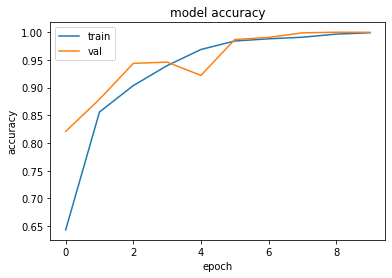

In [17]:
import keras
from matplotlib import pyplot as plt
print(hist.history.keys())
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

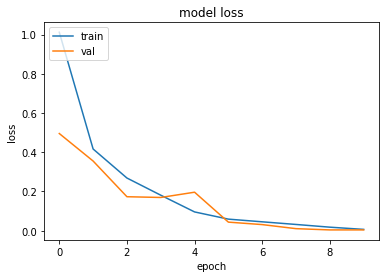

In [18]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()